In [6]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,Lasso

# Dataset

In [ ]:
hourlydata=xr.open_dataset(r'C:\Users\Harshit Jain\Desktop\delhiaq\daily_data.nc')
df=hourlydata.to_dataframe()
#print(df1)
df.dropna(subset=['PM2.5'],inplace=True)

df.reset_index(inplace=True)
df.columns = df.columns.str.lower()
print(df.shape)

df = df[df['date'].dt.year != 2023]
df=df[df['date']=='2022-08-23']
df.rename(columns={'Date':'date','pm2.5':'pm25','ozone':'o3','tot-rf':'totrf'}, inplace=True)
print(df)
#df = df[df['station'] == 'Wazirpur, Delhi - DPCC']


# Rectified Plot

In [8]:
def interpolPlot(
    df,
    shape_df,
    long,
    lat,
    pollutant,
    Interpolator,
    resolution=100,
    partitions=15,
    cmap="inferno",
    Tcolor="k",
    markersize=3,
    plot_train_points=False,
    extrapolate=True,
):
    """Interpolates data at unknown locations--based on the passed
    `Interpolator`--and plots them on a geographical plot.

    Parameters
    ----------

    df: data frame 
        minimally containing latitude and longitude
        and pollutant value

    shape_df: geo pandas data frame 
       minimally containing DISTRICT    and geometry

    long: str
        name of column in df having longitudes

    lat: str
        name of column in df having latitudes

    pollutant: str
        name of column in df having pollutant values.

    Interpolator: sklean estimator
        Interpolator to be used to interpolate values.
        eg. Lasso from sklearn.linear_models

    resolution: int
        Resolution at which to interpolate. Bigger number 
        means more granularity.

    partitions: int
        Levels in the contour created.

    cmap: str or matplotlib.colors.ListedColormap
        cmap to be used while creating contours

    Tcolor: str
        Color to be used while plotting training points.

    markersize: float
        Training Point markersize. 
        (Also varies with the amount of pollution found)            

    plot_train_points: bool
        If True, plots, the training points used to interpolate.

    extrapolate: bool
        If False, limits interpolation within bounds of the
        training points used.
    """

    import geopandas
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from geopandas import GeoDataFrame
    from matplotlib.colors import ListedColormap
    from shapely.geometry import Polygon, MultiPolygon, Point

    df = df.sample(frac=1)
    trainX = df[[long, lat]].values
    trainy = df[pollutant].values

    def bounds_minmax(bound1, bound2=None):
        if bound2 is None:
            return bound1
        temp = []
        temp.append(min(bound1[0], bound2[0]))
        temp.append(min(bound1[1], bound2[1]))
        temp.append(max(bound1[2], bound2[2]))
        temp.append(max(bound1[3], bound2[3]))
        return temp

    def collec_to_gdf(collec_poly):
        """Transform a `matplotlib.contour.QuadContourSet` to a GeoDataFrame"""
        polygons, colors = [], []
        for i, polygon in enumerate(collec_poly.collections):
            mpoly = []
            for path in polygon.get_paths():
                try:
                    path.should_simplify = False
                    poly = path.to_polygons()
                    # Each polygon should contain an exterior ring + maybe hole(s):
                    exterior, holes = [], []
                    if len(poly) > 0 and len(poly[0]) > 3:
                        # The first of the list is the exterior ring :
                        exterior = poly[0]
                        # Other(s) are hole(s):
                        if len(poly) > 1:
                            holes = [h for h in poly[1:] if len(h) > 3]
                    mpoly.append(Polygon(exterior, holes))
                except:
                    print("Warning: Geometry error when making polygon #{}".format(i))
            if len(mpoly) > 1:
                mpoly = MultiPolygon(mpoly)
                polygons.append(mpoly)
                colors.append(polygon.get_facecolor().tolist()[0])
            elif len(mpoly) == 1:
                polygons.append(mpoly[0])
                colors.append(polygon.get_facecolor().tolist()[0])
        if type(collec_poly.cmap) != ListedColormap:
            raise ValueError(
                """We only support ListedColormap right now.\n"""
                """simply convert your cmap to ListedColormap using url here."""
                """https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html#sphx-glr-tutorials-colors-colormap-manipulation-py"""
            )

        ixs = [collec_poly.cmap.colors.index(c[:3]) for c in colors]
        return GeoDataFrame(
            geometry=polygons,
            data={"RGBA": colors, "cmapIX": ixs},
            crs={"init": "epsg:4269"},
        )

    z = trainy
    if not extrapolate:
        x1max, x2max = np.max(trainX, axis=0)
        x1min, x2min = np.min(trainX, axis=0)
    else:
        bounds = None
        for index, row in shape_df.iterrows():
            poly = row["geometry"]
            bounds = bounds_minmax(poly.bounds, bounds)

        x1max, x2max = bounds[2:]
        x1min, x2min = bounds[:2]
    xi = np.linspace(x1min, x1max, resolution)
    yi = np.linspace(x2min, x2max, resolution)
    Xi, Yi = np.meshgrid(xi, yi)
    t = Interpolator
    t.fit(trainX, z)

    zi = t.predict(np.asarray([Xi.ravel(), Yi.ravel()]).T)
    zi = zi.reshape(Xi.shape)

    vmin = zi.min()
    vmax = zi.max()
    collec_poly = plt.contourf(Xi, Yi, zi, partitions, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.close()

    gdf = collec_to_gdf(collec_poly)
    # new min max vales in term of index of colors
    vmax2 = gdf.cmapIX.max()
    vmin2 = gdf.cmapIX.min()

    # intersection with shape_df
    inter = geopandas.overlay(shape_df, gdf, how="intersection")
    ax = inter.plot(
        column="cmapIX", cmap=cmap, figsize=(12, 12), vmax=vmax2, vmin=vmin2,
    )
    ax = shape_df.plot(ax=ax, color="none", edgecolor="k", figsize=(12, 12))
    # getting geodataframe of the train points
    if plot_train_points:
        geometry = [Point(xy) for xy in zip(df[long], df[lat])]
        geodf = geopandas.GeoDataFrame(df, crs={"init": "epsg:4269"}, geometry=geometry)

        # finding the intersection and plotting
        from geopandas.tools import sjoin

        inter2 = sjoin(geodf, shape_df)
        inter2.plot(
            ax=ax,
            color=Tcolor,
            label="Train points",
            markersize=markersize * df[pollutant].values,
        )
    try:
        plt.axis("off")
        fig = ax.get_figure()
        cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        ax.legend()

        bounds = np.linspace(vmin, vmax, partitions)
        fig.colorbar(sm, cax=cax, ticks=bounds, boundaries=bounds, format="%.2f")
    except ValueError:
        print("Plotting without colorbar.")

    return ax

#     plt.axis("off")
#     fig = ax.get_figure()
#     cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     ax.legend()

#     bounds = np.linspace(vmin, vmax, partitions)
#     fig.colorbar(sm, cax=cax, ticks=bounds, 
#         boundaries=bounds, format="%.2f")
#     return ax




# Shape File

C:\Users\Harshit Jain\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Harshit Jain\AppData\Local\Temp\ipykernel_13432\2309777049.py:162: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4269 +type=crs

  inter = geopandas.overlay(shape_df, gdf, how="intersection")
C:\Users\Harshit Jain\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be

Plotting without colorbar.


C:\Users\Harshit Jain\anaconda3\lib\site-packages\matplotlib\colorbar.py:1243: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -
C:\Users\Harshit Jain\AppData\Local\Temp\ipykernel_13432\2309777049.py:191: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  fig.colorbar(sm, cax=cax, ticks=bounds, boundaries=bounds, format="%.2f")


<Axes: >

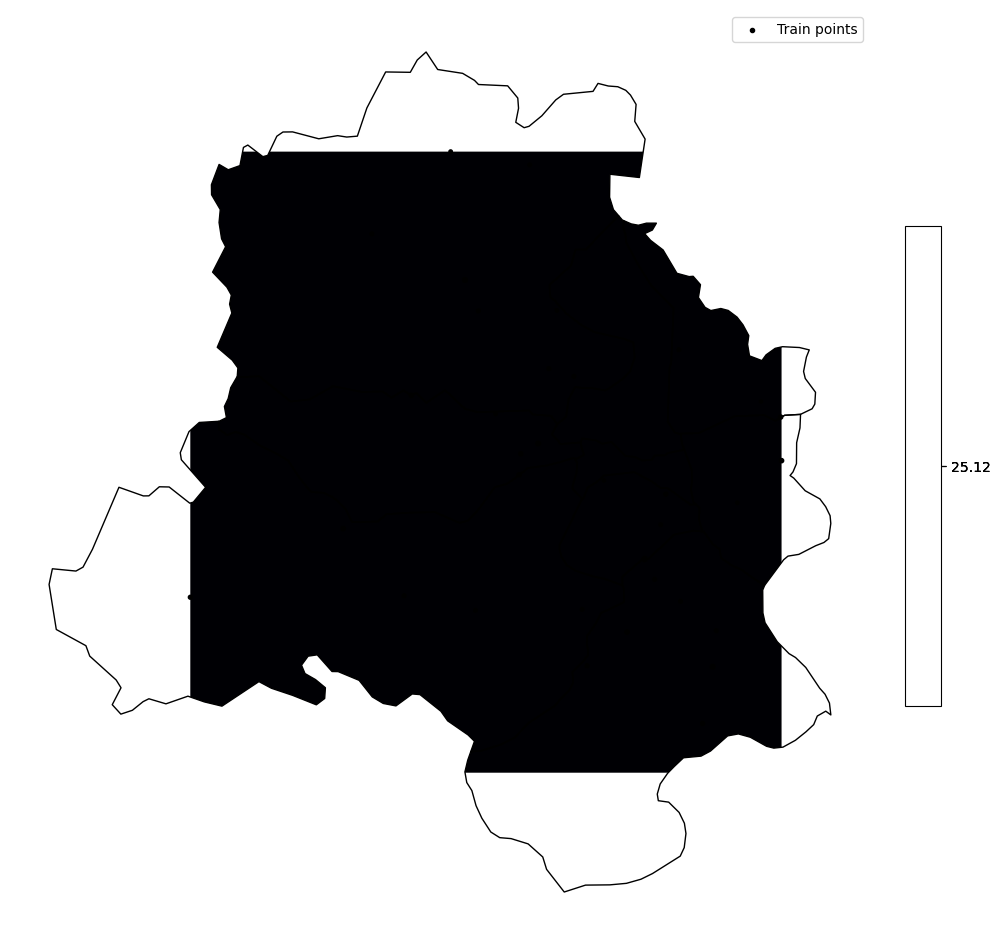

In [9]:

gdf_shape = (r'C:\Users\Harshit Jain\Desktop\delhiaq\Delhi\Districts.shp')
gdf_shape = gpd.read_file(gdf_shape)

interpolator = Lasso()

df.dropna(subset=['pm25'],inplace=True)

interpolPlot(df, gdf_shape, 'longitude','latitude', 'pm25', interpolator, resolution=50, partitions=3, cmap='inferno', Tcolor='k', markersize=0.3, plot_train_points=True, extrapolate=False)
#interpolPlot(df1, gdf_shape, x,y, 'pm25', interpolator, resolution=50, partitions=15, cmap='inferno', Tcolor='k', markersize=3, plot_train_points=False, extrapolate=False)